In [1]:
import torch
import torch.nn as nn

In [2]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial 
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [3]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016, 
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
    
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [4]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1 
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """
        
        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28), 
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        

    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon. 
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index 
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        ''' 

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])
        
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t)) 
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        
        return mean + std*epsilon

    
    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image            
        """
        
        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)            
            xt = self.reverse_diffusion(xt, t, noise)

        return xt

    
    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
        
        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)
        
        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t))

    
    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


/home/arn/Documents/PML/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def check_memorization_ratio(generated_samples, training_dataset_tensor, k=1/3):
    dists = torch.cdist(generated_samples, training_dataset_tensor, p=2)

    top2_dists, _ = dists.topk(k=2, dim=1, largest=False)
    
    d1 = top2_dists[:, 0] 
    d2 = top2_dists[:, 1] 

    ratios = d1 / d2
    
    is_memorized = ratios < k
    
    return is_memorized, ratios

best_memorization_list = []

def reporter(model, ground_images):
    """Callback function used for plotting images during training"""
    
    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 50
        samples = model.sample((nsamples,28*28))
        
        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2 

        is_memorized, ratios = check_memorization_ratio(samples, ground_images, k=1/3)
        
        top_k = 5
        best_samples = torch.argsort(ratios)[:top_k]

        # save best memorization ratio
        best_memorization_list.append(ratios[best_samples[0]].item())

        samples = samples.clamp(0.0, 1.0)


        fig, axes = plt.subplots(1, 5, figsize=(10, 2))
        for i, ax in enumerate(axes):
            img = transforms.functional.to_pil_image(samples[best_samples[i]].reshape(28,28))
            ax.imshow(img, cmap="gray")
            ax.axis('off')
            ax.text(2, 26, f"{ratios[best_samples[i]]: .5f}", color='green',
                            fontsize=12, ha='left', va='bottom',
                            bbox=dict(facecolor='black', alpha=0.7, pad=1))
        plt.tight_layout()
        plt.show()


In [6]:
# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

def dataset_mnist(batch_size):
    # Download and transform train dataset
    mnist_dataset = datasets.MNIST('./mnist_data', download=True, train=True, transform=transform)
    
    # Use RandomSampler to draw exactly 'batch_size' samples per epoch.
    # replacement=True with num_samples ensures we get a random set of 10 items 
    # from the full dataset each time the loop restarts.
    sampler = torch.utils.data.RandomSampler(mnist_dataset, replacement=True, num_samples=batch_size)
    
    dataloader_train = torch.utils.data.DataLoader(mnist_dataset,
                                                    batch_size=batch_size,
                                                    sampler=sampler)
    return dataloader_train

def dataset_zero_to_nine(batch_size):
    # Download and transform train dataset
    mnist_dataset_base = datasets.MNIST('./mnist_data', download=True, train=True, transform=transform)


    # Take only 10 samples for training — create a separate MNIST instance and repeat first 10 to match base size
    dataset_size = 10
    mnist_dataset = datasets.MNIST('./mnist_data', download=False, train=True, transform=transform)

    # Select one image of each digit 0-9
    indices_one_of_each = []
    for digit in range(10):
        idx = (mnist_dataset.targets == digit).nonzero(as_tuple=True)[0][0]
        indices_one_of_each.append(idx)

    indices_one_of_each = torch.stack(indices_one_of_each)

    # Select the collected images
    mnist_dataset.data = mnist_dataset.data[indices_one_of_each]
    mnist_dataset.targets = mnist_dataset.targets[indices_one_of_each]

    dataloader_train = torch.utils.data.DataLoader(mnist_dataset,
                                                    batch_size=batch_size,
                                                    shuffle=True)
    
    return dataloader_train

def dataset_same_number(batch_size, number):
    # Download and transform train dataset
    mnist_dataset_base = datasets.MNIST('./mnist_data', download=True, train=True, transform=transform)


    # Take only 10 samples for training — create a separate MNIST instance and repeat first 10 to match base size
    dataset_size = 10
    mnist_dataset = datasets.MNIST('./mnist_data', download=False, train=True, transform=transform)

    # Find indices where target class is number
    target_indices = (mnist_dataset.targets == number).nonzero(as_tuple=True)[0]
    # Select the first 10 images with target number
    mnist_dataset.data = mnist_dataset.data[target_indices][:dataset_size]
    mnist_dataset.targets = mnist_dataset.targets[target_indices][:dataset_size]
    dataloader_train = torch.utils.data.DataLoader(mnist_dataset,
                                                    batch_size=batch_size,
                                                    shuffle=True)
    
    return dataloader_train

/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
Training:   0%|          | 1/50000 [00:00<12:04:56,  1.15it/s, epoch=1/50000, loss=⠀      6.7608, lr=1.00E-03]

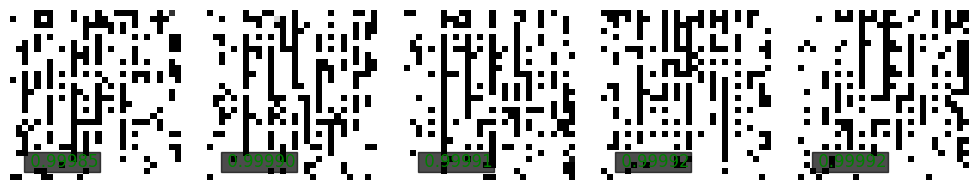

Training:   2%|▏         | 1000/50000 [00:11<07:34, 107.71it/s, epoch=1001/50000, loss=⠀      0.0525, lr=9.05E-04]

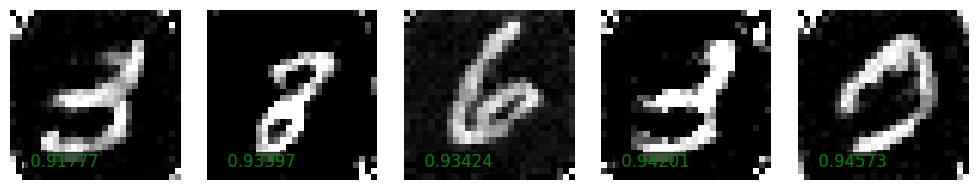

Training:   4%|▍         | 2000/50000 [00:22<06:56, 115.38it/s, epoch=2001/50000, loss=⠀      0.0215, lr=8.19E-04]

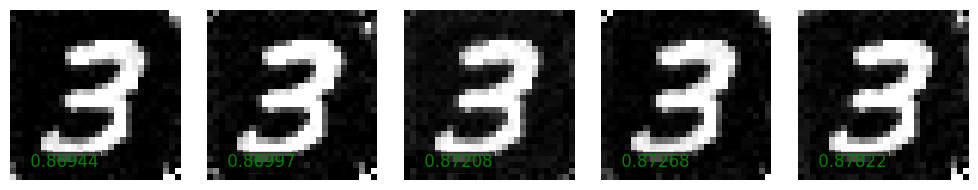

Training:   6%|▌         | 3000/50000 [00:33<07:24, 105.83it/s, epoch=3001/50000, loss=⠀      0.0252, lr=7.41E-04]

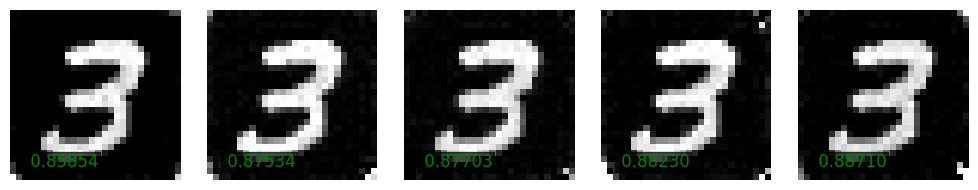

Training:   8%|▊         | 4000/50000 [00:45<07:14, 105.81it/s, epoch=4001/50000, loss=⠀      0.0163, lr=6.70E-04]

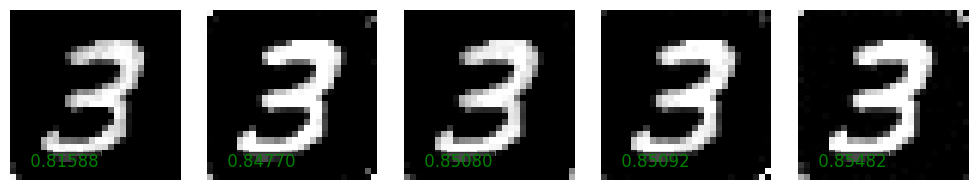

Training:  10%|█         | 5000/50000 [00:56<07:29, 100.03it/s, epoch=5001/50000, loss=⠀      0.0130, lr=6.06E-04]

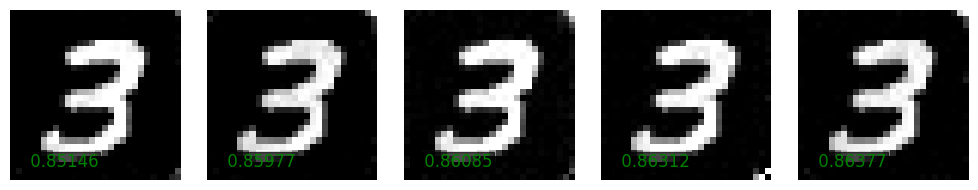

Training:  12%|█▏        | 6000/50000 [01:09<08:39, 84.63it/s, epoch=6001/50000, loss=⠀      0.0115, lr=5.49E-04] 

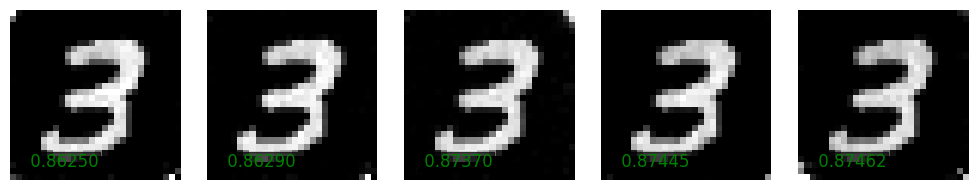

Training:  14%|█▍        | 7001/50000 [01:22<08:18, 86.28it/s, epoch=7001/50000, loss=⠀      0.0140, lr=4.97E-04]

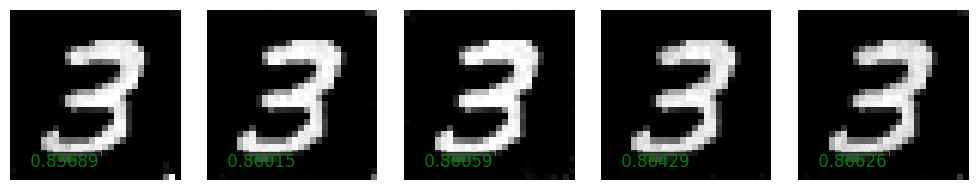

Training:  16%|█▌        | 8000/50000 [01:34<06:45, 103.61it/s, epoch=8001/50000, loss=⠀      0.0767, lr=4.49E-04]

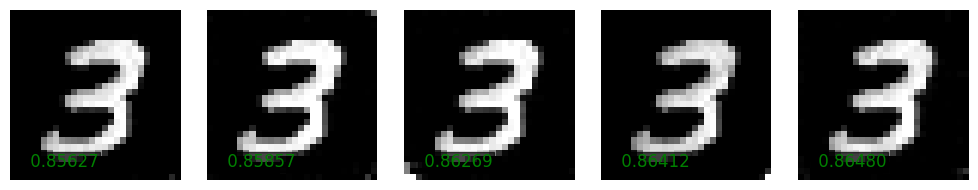

Training:  18%|█▊        | 9001/50000 [01:45<06:41, 102.10it/s, epoch=9001/50000, loss=⠀      0.0081, lr=4.07E-04]

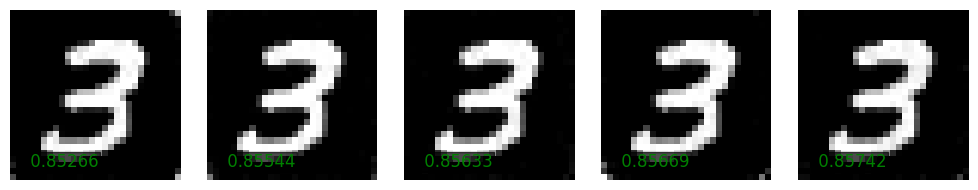

Training:  20%|██        | 10000/50000 [01:56<06:52, 97.04it/s, epoch=10001/50000, loss=⠀      0.0124, lr=3.68E-04]

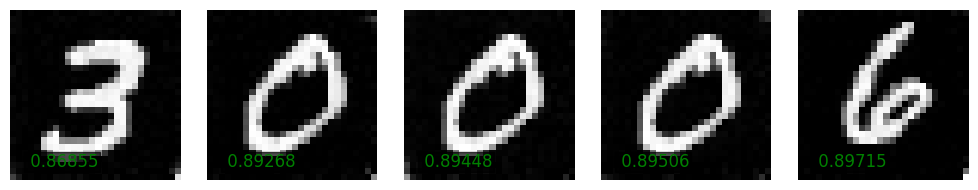

Training:  22%|██▏       | 11000/50000 [02:07<06:09, 105.65it/s, epoch=11001/50000, loss=⠀      0.0206, lr=3.33E-04]

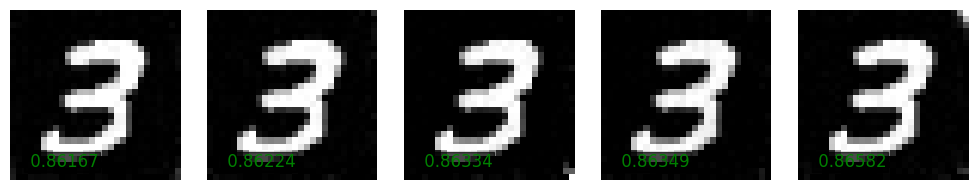

Training:  24%|██▍       | 12000/50000 [02:19<06:37, 95.69it/s, epoch=12001/50000, loss=⠀      0.0119, lr=3.01E-04] 

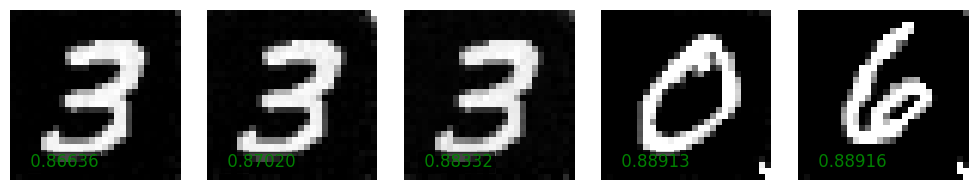

Training:  26%|██▌       | 13000/50000 [02:31<05:56, 103.85it/s, epoch=13001/50000, loss=⠀      0.0092, lr=2.72E-04]

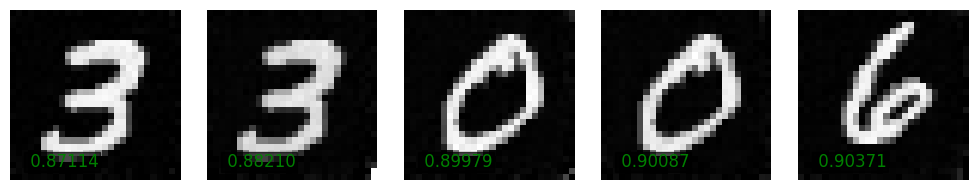

Training:  28%|██▊       | 14000/50000 [02:43<05:53, 101.80it/s, epoch=14001/50000, loss=⠀      0.0126, lr=2.47E-04]

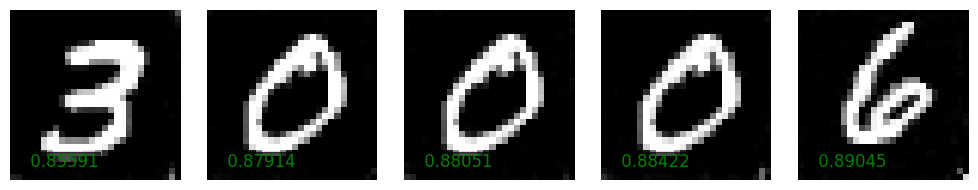

Training:  30%|███       | 15000/50000 [02:56<07:20, 79.51it/s, epoch=15001/50000, loss=⠀      0.0075, lr=2.23E-04] 

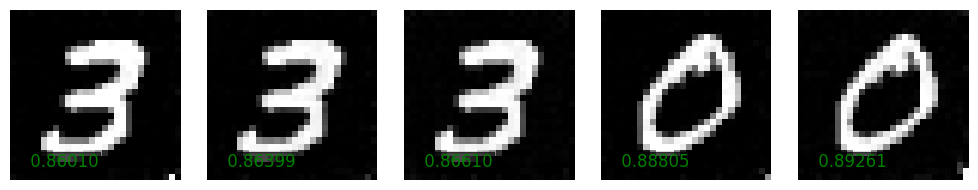

Training:  32%|███▏      | 16000/50000 [03:09<05:24, 104.91it/s, epoch=16001/50000, loss=⠀      0.0086, lr=2.02E-04]

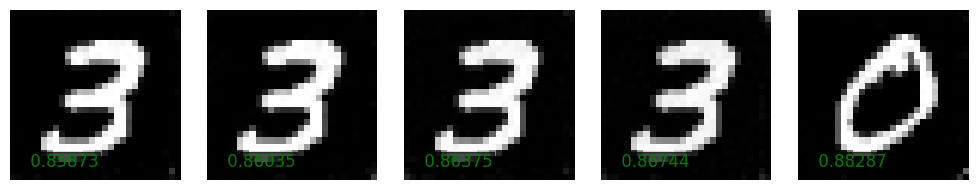

Training:  34%|███▍      | 17000/50000 [03:20<04:52, 112.87it/s, epoch=17001/50000, loss=⠀      0.0115, lr=1.83E-04]

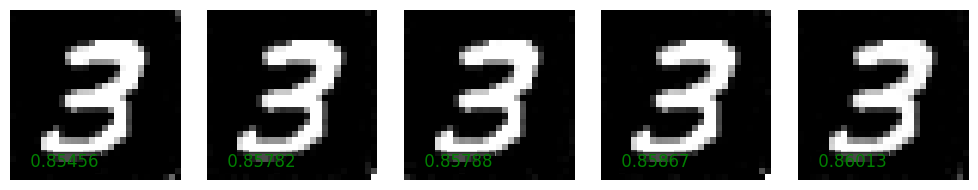

Training:  36%|███▌      | 18000/50000 [03:31<05:09, 103.53it/s, epoch=18001/50000, loss=⠀      0.0075, lr=1.65E-04]

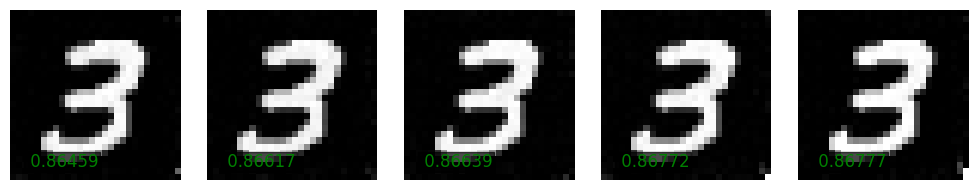

Training:  38%|███▊      | 19000/50000 [03:42<05:05, 101.50it/s, epoch=19001/50000, loss=⠀      0.0185, lr=1.50E-04]

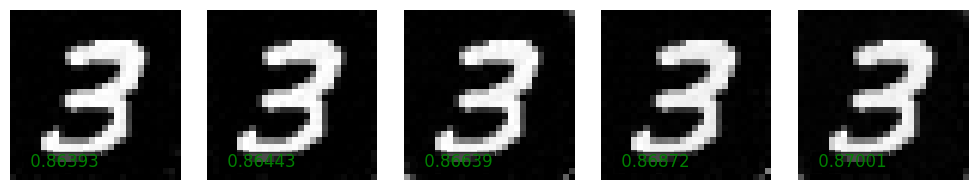

Training:  40%|████      | 20000/50000 [03:54<04:49, 103.53it/s, epoch=20001/50000, loss=⠀      0.0059, lr=1.35E-04]

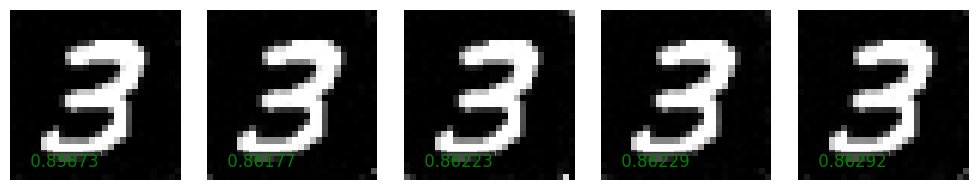

Training:  42%|████▏     | 21000/50000 [04:06<04:45, 101.58it/s, epoch=21001/50000, loss=⠀      0.0059, lr=1.22E-04]

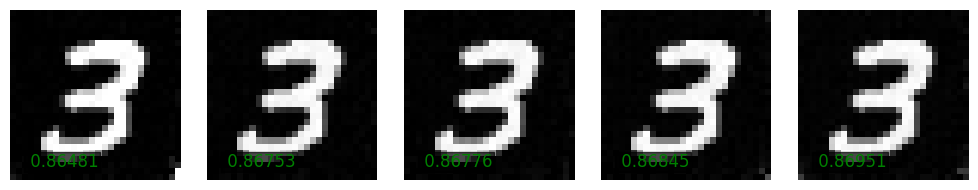

Training:  44%|████▍     | 22000/50000 [04:18<04:38, 100.48it/s, epoch=22001/50000, loss=⠀      0.0083, lr=1.11E-04]

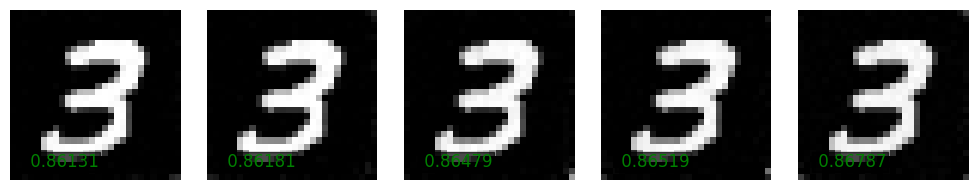

Training:  46%|████▌     | 23000/50000 [04:30<04:58, 90.53it/s, epoch=23001/50000, loss=⠀      0.0054, lr=1.00E-04] 

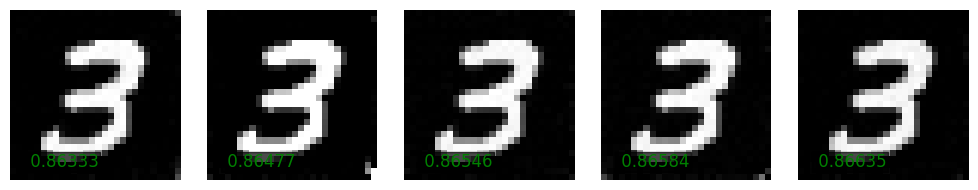

Training:  48%|████▊     | 24000/50000 [04:44<05:18, 81.71it/s, epoch=24001/50000, loss=⠀      0.0062, lr=9.07E-05]

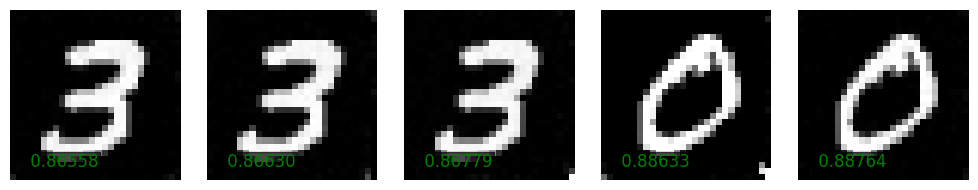

Training:  50%|█████     | 25000/50000 [04:55<03:39, 113.74it/s, epoch=25001/50000, loss=⠀      0.0057, lr=8.21E-05]

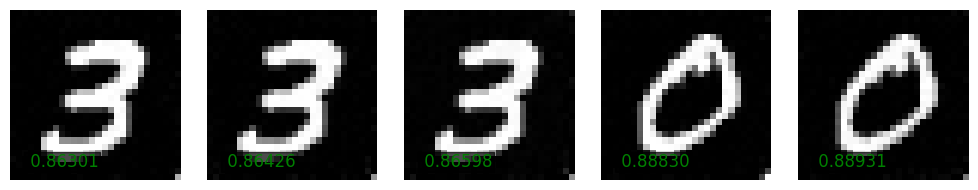

Training:  52%|█████▏    | 26000/50000 [05:05<03:23, 117.75it/s, epoch=26001/50000, loss=⠀      0.0061, lr=7.43E-05]

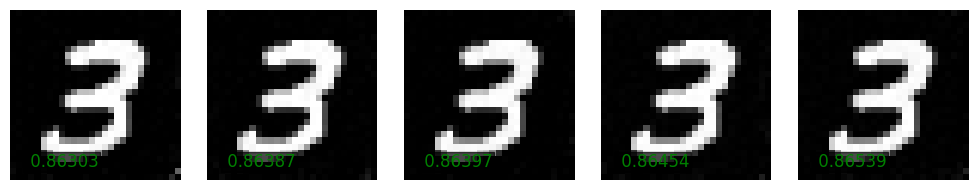

Training:  54%|█████▍    | 27000/50000 [05:16<03:19, 115.32it/s, epoch=27001/50000, loss=⠀      0.0049, lr=6.72E-05]

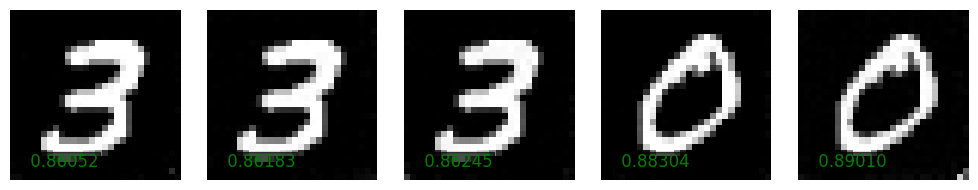

Training:  56%|█████▌    | 28000/50000 [05:26<03:01, 121.52it/s, epoch=28001/50000, loss=⠀      0.0068, lr=6.08E-05]

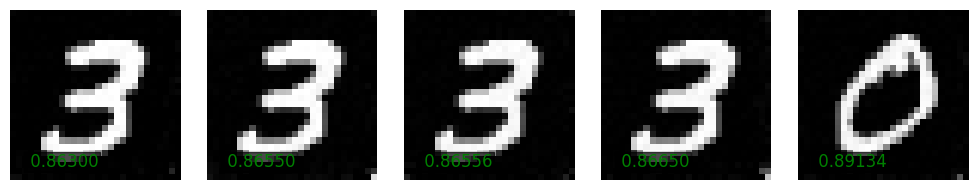

Training:  58%|█████▊    | 29000/50000 [05:36<03:16, 106.96it/s, epoch=29001/50000, loss=⠀      0.0043, lr=5.50E-05]

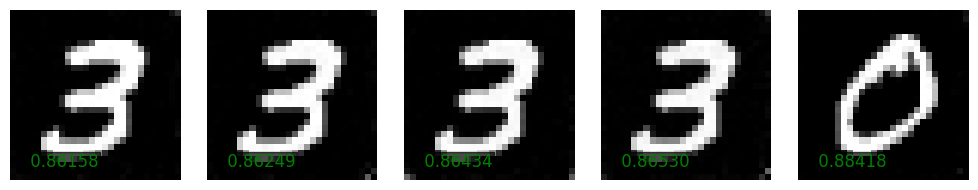

Training:  60%|██████    | 30000/50000 [05:48<03:20, 99.69it/s, epoch=30001/50000, loss=⠀      0.0042, lr=4.98E-05] 

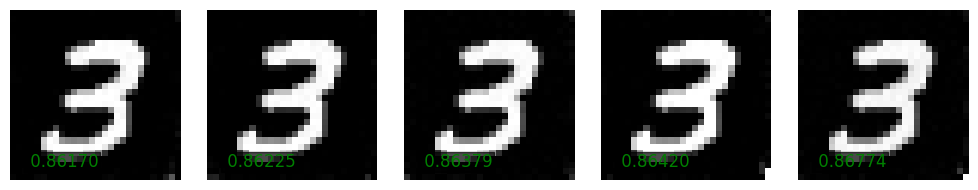

Training:  62%|██████▏   | 31000/50000 [06:00<03:26, 91.85it/s, epoch=31001/50000, loss=⠀      0.0084, lr=4.50E-05] 

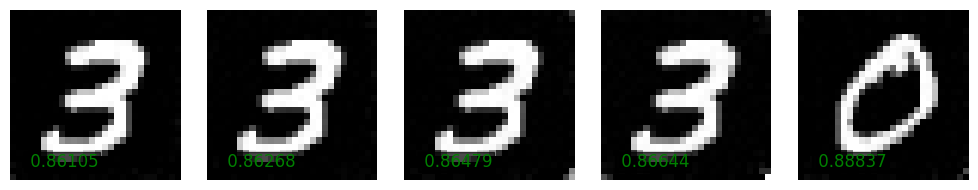

Training:  64%|██████▍   | 32000/50000 [06:14<03:36, 83.15it/s, epoch=32001/50000, loss=⠀      0.0044, lr=4.08E-05]

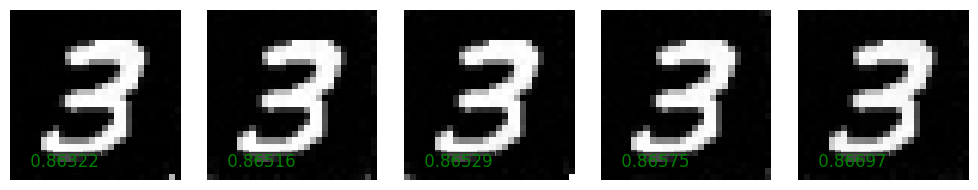

Training:  66%|██████▌   | 33000/50000 [06:27<02:39, 106.50it/s, epoch=33001/50000, loss=⠀      0.0142, lr=3.69E-05]

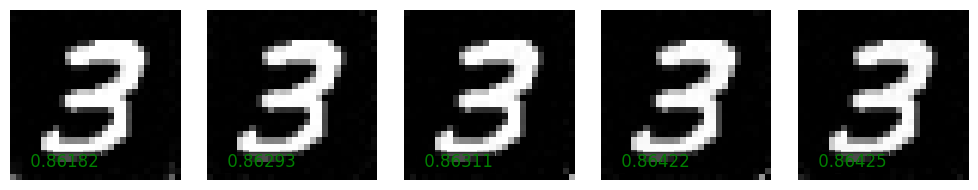

Training:  68%|██████▊   | 34000/50000 [06:39<02:44, 97.46it/s, epoch=34001/50000, loss=⠀      0.0080, lr=3.34E-05] 

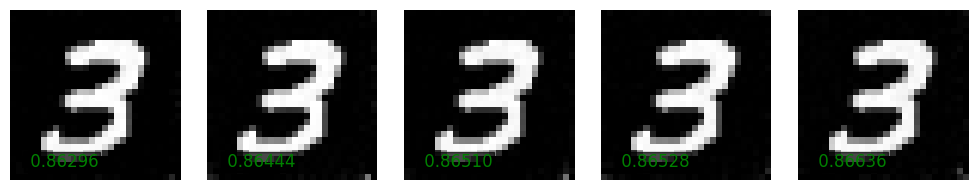

Training:  70%|███████   | 35000/50000 [06:50<02:19, 107.57it/s, epoch=35001/50000, loss=⠀      0.0050, lr=3.02E-05]

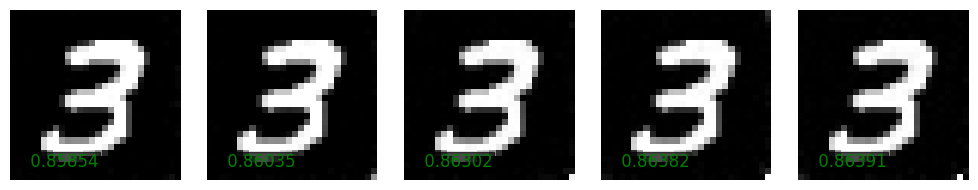

Training:  72%|███████▏  | 36000/50000 [07:01<02:22, 98.58it/s, epoch=36001/50000, loss=⠀      0.0049, lr=2.73E-05] 

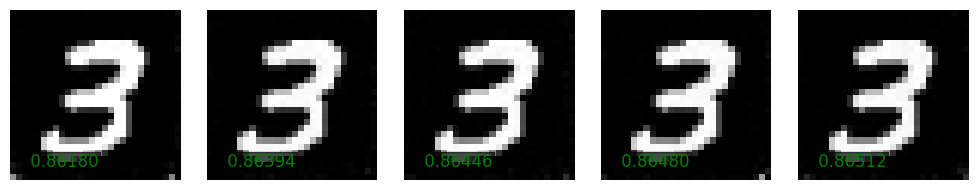

Training:  74%|███████▍  | 37000/50000 [07:14<02:17, 94.79it/s, epoch=37001/50000, loss=⠀      0.0071, lr=2.47E-05] 

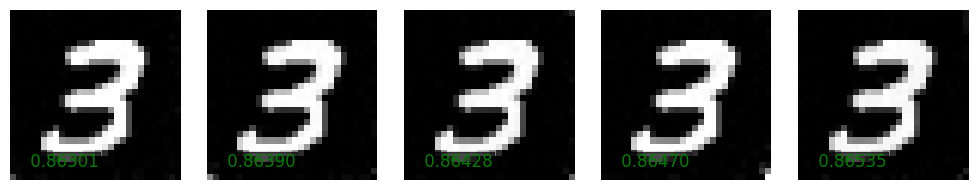

Training:  76%|███████▌  | 38000/50000 [07:26<02:05, 95.80it/s, epoch=38001/50000, loss=⠀      0.0051, lr=2.24E-05] 

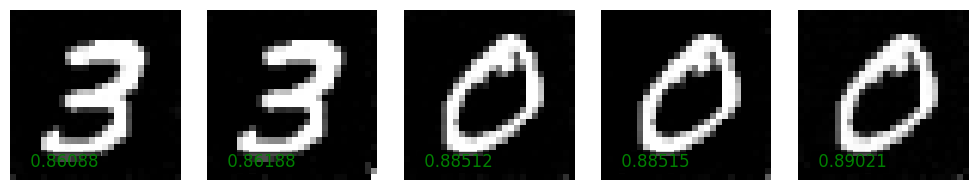

Training:  78%|███████▊  | 39000/50000 [07:38<01:56, 94.06it/s, epoch=39001/50000, loss=⠀      0.0057, lr=2.02E-05] 

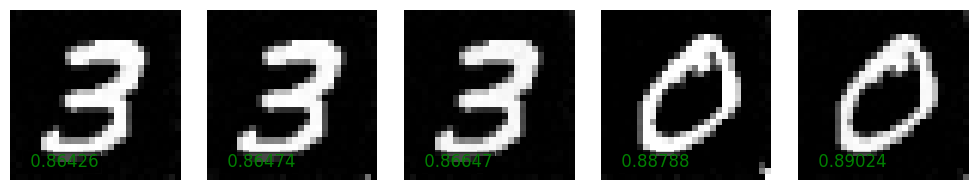

Training:  80%|████████  | 40000/50000 [07:51<02:03, 80.65it/s, epoch=40001/50000, loss=⠀      0.0051, lr=1.83E-05] 

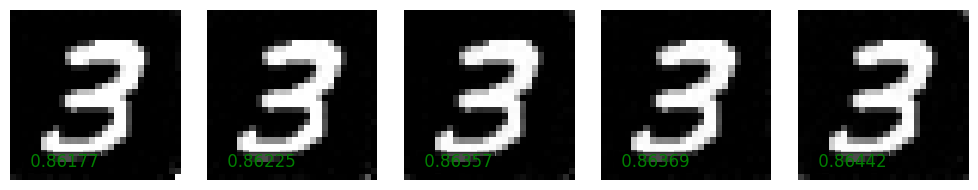

Training:  82%|████████▏ | 41000/50000 [08:05<01:49, 82.52it/s, epoch=41001/50000, loss=⠀      0.0081, lr=1.66E-05]

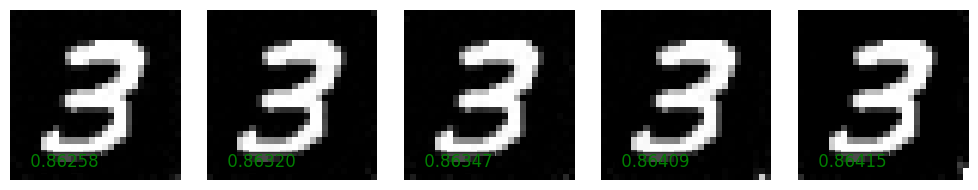

Training:  84%|████████▍ | 42000/50000 [08:17<01:19, 100.23it/s, epoch=42001/50000, loss=⠀      0.0058, lr=1.50E-05]

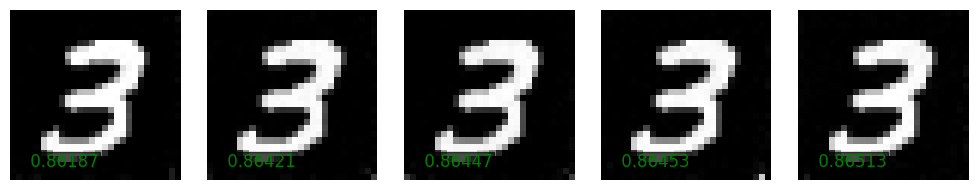

Training:  86%|████████▌ | 43000/50000 [08:28<01:04, 108.35it/s, epoch=43001/50000, loss=⠀      0.0213, lr=1.36E-05]

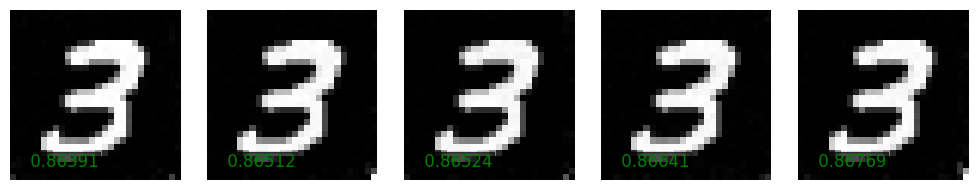

Training:  88%|████████▊ | 44000/50000 [08:39<00:59, 100.27it/s, epoch=44001/50000, loss=⠀      0.0046, lr=1.23E-05]

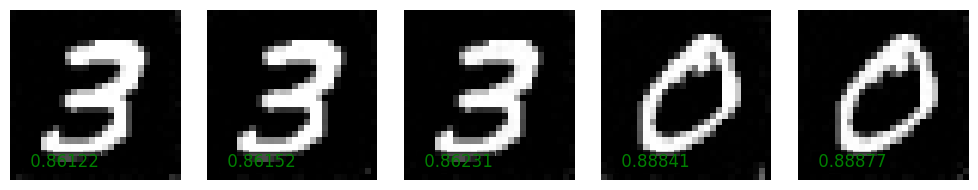

Training:  90%|█████████ | 45000/50000 [08:51<00:53, 92.88it/s, epoch=45001/50000, loss=⠀      0.0044, lr=1.11E-05] 

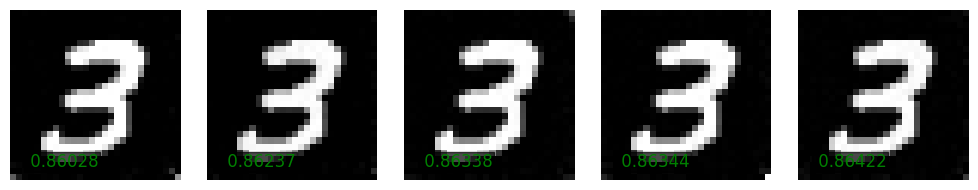

Training:  92%|█████████▏| 46000/50000 [09:03<00:45, 88.00it/s, epoch=46001/50000, loss=⠀      0.0049, lr=1.00E-05] 

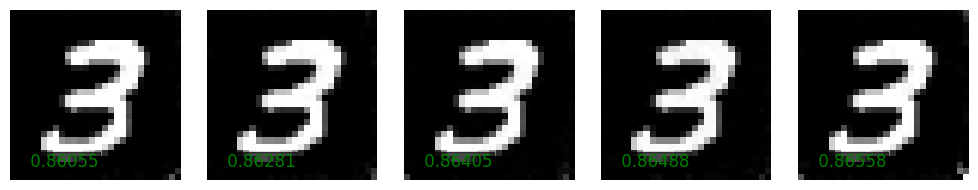

Training:  94%|█████████▍| 47000/50000 [09:16<00:30, 97.75it/s, epoch=47001/50000, loss=⠀      0.0057, lr=9.09E-06] 

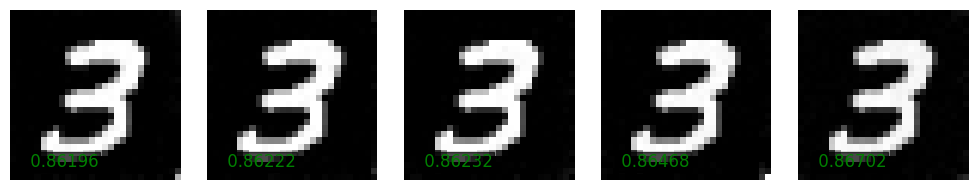

Training:  96%|█████████▌| 48000/50000 [09:28<00:23, 85.56it/s, epoch=48001/50000, loss=⠀      0.0054, lr=8.23E-06] 

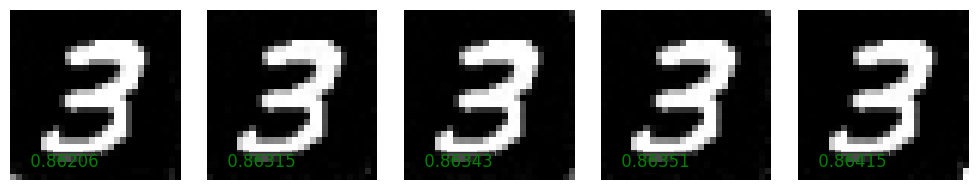

Training:  98%|█████████▊| 49000/50000 [09:42<00:12, 78.84it/s, epoch=49001/50000, loss=⠀      0.0067, lr=7.44E-06]

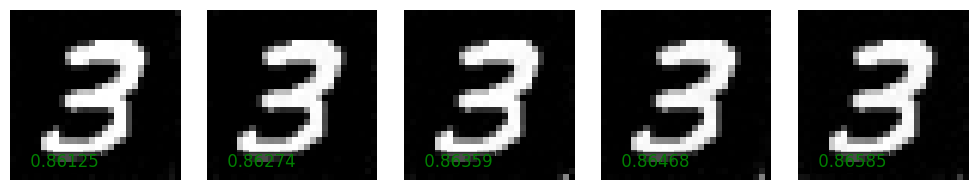

Training: 100%|██████████| 50000/50000 [09:54<00:00, 84.11it/s, epoch=50000/50000, loss=⠀      0.0041, lr=6.74E-06] 


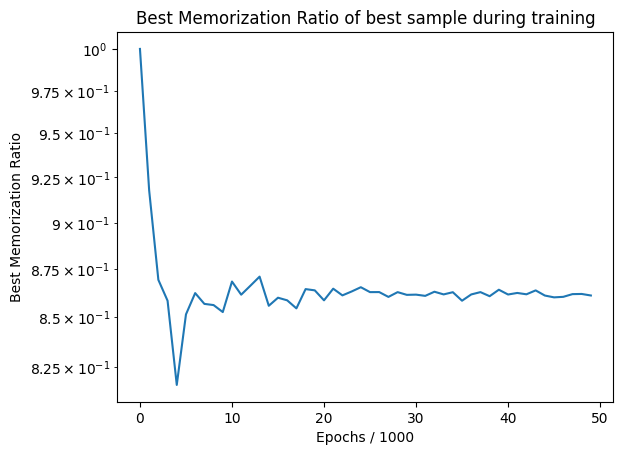

0.8158811330795288


In [7]:


def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop
    
    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")
    
    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()            
        
        if per_epoch_callback:
            if epoch % 1000 == 0:
                images = dataloader.dataset.data.reshape(-1, 28*28).float().to(device)/255.0*2.0 - 1.0
                per_epoch_callback(model, images)


# Parameters
T = 1000
learning_rate = 1e-3
epochs = 50000
batch_size = 10

dataloader_train = dataset_zero_to_nine(batch_size)
#dataloader_train = dataset_same_number(batch_size, 1)
#dataloader_train = dataset_mnist(batch_size)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)),channels=[32 * 1, 64 * 1, 128 * 1, 256 * 1])

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

# Call training loop
train(model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=False, per_epoch_callback=reporter)

plt.plot(best_memorization_list)
plt.yscale("log")
plt.xlabel("Epochs / 1000")
plt.ylabel("Best Memorization Ratio")
plt.title("Best Memorization Ratio of best sample during training")
plt.show()

print(min(best_memorization_list))